##  Flatten FHIR Observations to Panda Dataframe and do some stats on them

1. Fetch a series of FHIR Observations
1. Flatten them and create a Panda Dataframe
1. Perform several stats operations on them

In [4]:
from pathlib import Path 
from json import dumps,loads
from pandas import *
from requests import get
from IPython.display import display as Display,HTML

ref_server ='http://hapi.fhir.org/baseR4'
#ref_server ='http://hapi.fhir.org/baseR5'
headers = {
    'Accept':'application/fhir+json',
    'Content-Type':'application/json'
    }


### Using GraphQL with FHIR we can extract and flatten data in dataframes for Pandas

See:  http://build.fhir.org/graphql.html

for example using the graphql expresssion:
`{{url}}/$graphql?query={PatientList{name@flatten@first{text,given@first,family}}}` 

for the server: http://hapi.fhir.org/baseR4

we get the output...

In [5]:
params = dict(
    query = "{PatientList{name@flatten@first{text,given@first,family}}}"
    )
params

{'query': '{PatientList{name@flatten@first{text,given@first,family}}}'}

In [6]:
r = get(f'{ref_server}/$graphql', params = params, headers = headers )
Display(HTML(
    '<h1>Response</h1>'
    f'<h3>Status Code = {r.status_code}</h3>'
    f'<pre>{r.json()}</pre>'
    ))

## Transform the output into a Pandas DataFrame...

In [7]:
patients = r.json()['data']['PatientList']
df = DataFrame(patients)


df.head()

,given,family,text
0,Veera,Radonctest,NaN
1,Xavier,Cooper,Xavier Cooper
2,Peter,IchDenkeMal,NaN
3,Jack,Ma,NaN
4,Peter,Bond,NaN


### Then you can do all your data analysis...

In [8]:
df.describe()

,given,family,text
count,497,497,149
unique,21,390,144
top,Series_Status: Not complete,Alexander,This test case describes when dose #3 of the H...
freq,307,21,2


In [6]:
df.dtypes

given     object
family    object
text      object
dtype: object

### Try doing stats on Observations

- retrieve  some random Observation data  using GraphQL
   - elements of interest: 
        - `{valueQuantity{value}}`
        - `{effectivePeriod{end}}`
        
- convert to a dataframe and do stats on it using Pandas.

In [10]:
params = dict(
    query = "{ObservationList(subject:example){"  #,code{coding{code:foo}}){"
      "id,"
    "code@flatten{"
        "coding@flatten@first{"
            "code"
        "},"
        "text"
        "},"
  "valueQuantity@flatten{"
    "value,unit"
   "},"
  "effectivePeriod"#{"
    #"start" #end"
   #"}"
  "}"
 "}"
    )
params

{'query': '{ObservationList(subject:example){id,code@flatten{coding@flatten@first{code},text},valueQuantity@flatten{value,unit},effectivePeriod}}'}

In [11]:
r = get(f'{ref_server}/$graphql', params = params, headers = headers )
Display(HTML(
    '<h1>Response</h1>'
    f'<h3>Status Code = {r.status_code}</h3>'
    f'<pre>{r.json()}</pre>'
    ))

In [12]:
obs = r.json()['data']['ObservationList']
df = DataFrame(obs)
df.head()

,id,code,text,value,unit,effectivePeriod
0,Observation/85922/_history/1,8867-4,Heart rate,44.0,beats/minute,1999-07-02
1,Observation/251497/_history/1,29463-7,NaN,185.0,lbs,2016-03-28
2,Observation/251499/_history/1,29463-7,NaN,185.0,lbs,2016-03-28
3,Observation/251498/_history/1,29463-7,NaN,185.0,lbs,2016-03-28
4,Observation/251500/_history/1,29463-7,NaN,185.0,lbs,2016-03-28


In [13]:
df.dtypes

id                  object
code                object
text                object
value              float64
unit                object
effectivePeriod     object
dtype: object

### Convert effectivePeriod to datetime object

In [14]:
df['effectivePeriod'] = to_datetime(df.effectivePeriod)
df.dtypes

id                         object
code                       object
text                       object
value                     float64
unit                       object
effectivePeriod    datetime64[ns]
dtype: object

### Plot cumulative values by date

#### First list code value by date

In [15]:
df[['code','value','unit','effectivePeriod']]

,code,value,unit,effectivePeriod
0,8867-4,44.0,beats/minute,1999-07-02
1,29463-7,185.0,lbs,2016-03-28
2,29463-7,185.0,lbs,2016-03-28
3,29463-7,185.0,lbs,2016-03-28
4,29463-7,185.0,lbs,2016-03-28
5,29463-7,185.0,lbs,2016-03-28
6,29463-7,185.0,lbs,2016-03-28
7,8310-5,36.5,C,1999-07-02
8,8310-5,36.5,C,1999-07-02
9,8310-5,36.5,C,1999-07-02


### Now show cumulative value by date and plot as bar graph

- we will ignore normalizing the values to the same units for now

In [16]:
cum_results = df.resample('D', on='effectivePeriod').sum()
cum_results_1 = cum_results.loc[~(cum_results==0).all(axis=1)]  # show only non-zero values
cum_results_1

,value
effectivePeriod,
1996-07-02,10212.0
1999-07-02,573.7
2016-03-28,1110.0


In [17]:
%matplotlib inline

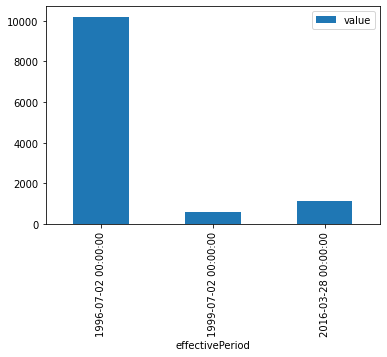

In [18]:
cum_results_1.plot.bar()